In [1]:
!pip install allennlp

import os
import sys
import json
import pickle
import random
import unicodedata
from tqdm import tqdm
from typing import Iterator, List, Dict
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
import nltk
from nltk.tokenize import word_tokenize
from allennlp.data.tokenizers import Token
from allennlp.data.fields import TextField, LabelField
from allennlp.data import Instance
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.models import Model
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper
from allennlp.modules.seq2vec_encoders import PytorchSeq2VecWrapper, Seq2VecEncoder
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.data.vocabulary import Vocabulary
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.modules.token_embedders import Embedding
from allennlp.data.iterators import BucketIterator,BasicIterator
from allennlp.training.trainer import Trainer
from allennlp.predictors import SentenceTaggerPredictor

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package cess_cat is

[nltk_data]    |   Package shakespeare is already up-to-date!
[nltk_data]    | Downloading package sinica_treebank to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package sinica_treebank is already up-to-date!
[nltk_data]    | Downloading package smultron to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package smultron is already up-to-date!
[nltk_data]    | Downloading package state_union to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package state_union is already up-to-date!
[nltk_data]    | Downloading package stopwords to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package stopwords is already up-to-date!
[nltk_data]    | Downloading package subjectivity to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[nltk_data]    |   Package subjectivity is already up-to-date!
[nltk_data]    | Downloading package swadesh to
[nltk_data]    |     /Users/zhengyuchen/nltk_data...
[n

True

# Wiki

In [2]:
wiki_dict = {}
folder = 'Wiki'
for file in tqdm(os.listdir(folder)):
    if not os.path.isdir(file):
        with open(folder + '/' + file, 'rb') as f:
            wiki_dict.update(pickle.load(f))
print(len(wiki_dict))

100%|██████████| 54/54 [00:34<00:00,  1.63it/s]


5379583


In [3]:
wiki_dict['Makani_Narayana_Rao']['6']

'Later appointed Permanent Judge of the Andhra Pradesh High Court on 11 July 1986 .\n'

# Distribution

In [0]:
input_path = 'Source/wiki-pages-text/'
wiki_dict = defaultdict(dict)

for i in tqdm(range(1, 110)):
    file_name = str(i).zfill(3)
    input_file = input_path + "wiki-" + file_name + '.txt'

    with open(input_file, 'r+') as wiki_file:
        for entry in wiki_file:
            entry = entry.split(' ')
            title = unicodedata.normalize('NFD', entry[0])
            label = unicodedata.normalize('NFD', entry[1])
            text = unicodedata.normalize('NFD', " ".join(entry[2:]))
            wiki_dict[title][label] = text

100%|██████████| 109/109 [02:16<00:00,  1.60s/it]


In [0]:
evidence_count = Counter()
sentence_length_count = Counter()
with open('Source/train.json', 'r') as t:
    train_json = json.load(t)
    for t in train_json:
        evidence_count[len(train_json[t]['evidence'])] += 1
        for e in train_json[t]['evidence']:
            sentence_length_count[len([word for word in word_tokenize(wiki_dict[e[0]][str(e[1])])])] += 1
res = evidence_count.most_common()
sentence_res = sentence_length_count.most_common()
res.sort()
sentence_res.sort()

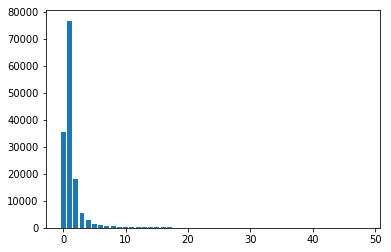

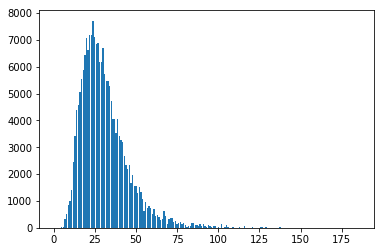

In [0]:
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in res],[j for i,j in res])
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in sentence_res],[j for i,j in sentence_res])

# Related Classifier

In [4]:
train=pickle.load(open('train_input.txt','rb'))
print(train[:2])

[{'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'label': 'SUPPORTS', 'evidence': [['The', 'Fox', 'Broadcasting', 'Company', '-LRB-', 'often', 'shortened', 'to', 'Fox', 'and', 'stylized', 'as', 'FOX', '-RRB-', 'is', 'an', 'American', 'English', 'language', 'commercial', 'broadcast', 'television', 'network', 'that', 'is', 'owned', 'by', 'the', 'Fox', 'Entertainment', 'Group', 'subsidiary', 'of', '21st', 'Century', 'Fox', '.\n'], ['He', 'then', 'played', 'Detective', 'John', 'Amsterdam', 'in', 'the', 'short-lived', 'Fox', 'television', 'series', 'New', 'Amsterdam', '-LRB-', '2008', '-RRB-', ',', 'as', 'well', 'as', 'appearing', 'as', 'Frank', 'Pike', 'in', 'the', '2009', 'Fox', 'television', 'film', 'Virtuality', ',', 'originally', 'intended', 'as', 'a', 'pilot', '.\n']]}, {'claim': 'Roman Atwood is a content creator.', 'label': 'SUPPORTS', 'evidence': [['He', 'is', 'best', 'known', 'for', 'his', 'vlogs', ',', 'where', 'he', 'posts', 'updates', 'about', 'his'

In [12]:
class VerbDatasetReader(DatasetReader):

    def __init__(self,sentence_indexers:Dict[str,TokenIndexer] = None)-> None:
        super().__init__(lazy=False)
        self.sentence_indexers=sentence_indexers or {"sentence":SingleIdTokenIndexer()}

    def text_to_instance(self, sentence:List[List],labels:str = None)->Instance:
        sent_tokenized=[]
        for sent in sentence:
            for word in word_tokenize(sent):
                sent_tokenized.append(Token(word))
        sentence_field=TextField(sent_tokenized,self.sentence_indexers)
        fields={'sentence':sentence_field,'labels':LabelField(labels)}
        return Instance(fields)

    def _read(self, file_path: str)->Iterator[Instance]:
        with open(file_path, 'rb') as f:
            train = pickle.load(f)
            for value in train[:1000]:
                if value['label'] == "NOT ENOUGH INFO":
                    title = random.choice(list(wiki_dict.keys()))
                    label = random.choice(list(wiki_dict[title].keys()))
                    instance = claim + ' ' + wiki_dict[title][label]
#                     print(title)
#                     print(label)
#                     print(wiki_dict[title][label])
                    yield self.text_to_instance(instance, value['label'])
                else:
                    claim = value['claim']
                    for e in value['evidence']:
                        instance = claim + ' '  + ' '.join(e)
    #                     print(instance)
                        yield self.text_to_instance(instance, value['label'])

reader=VerbDatasetReader()
train_dataset=reader.read('train_input.txt')

random.shuffle(train_dataset)

validation_set = train_dataset[:50]
train_set = train_dataset[50:]



0it [00:00, ?it/s]

1it [00:00,  2.04it/s]

6it [00:00,  2.86it/s]

8it [00:04,  1.18it/s]

10it [00:04,  1.58it/s]

11it [00:05,  1.91it/s]

17it [00:05,  2.69it/s]

23it [00:05,  3.76it/s]
28it [00:07,  3.44it/s]
33it [00:07,  4.76it/s]
41it [00:07,  6.63it/s]
46it [00:07,  7.86it/s]
50it [00:08,  6.96it/s]
55it [00:08,  8.04it/s]
58it [00:09,  7.21it/s]
62it [00:09,  8.16it/s]
64it [00:09,  8.11it/s]
72it [00:10, 10.09it/s]
80it [00:10, 13.65it/s]
86it [00:10, 17.54it/s]
90it [00:11,  9.95it/s]
93it [00:11,  9.67it/s]
98it [00:11, 10.82it/s]
103it [00:12, 11.89it/s]
105it [00:12, 10.07it/s]
113it [00:12, 13.61it/s]
121it [00:12, 18.11it/s]
128it [00:12, 23.24it/s]
134it [00:13, 22.38it/s]
143it [00:13, 28.65it/s]
150it [00:13, 34.48it/s]
156it [00:13, 38.33it/s]
162it [00:14, 22.02it/s]
167it [00:14, 20.40it/s]
171it [00:14, 13.50it/s]
175it [00:15, 13.71it/s]
184it [00:15, 18.30it/s]
189it [00:15, 14.45it/s]
193it [00:16, 11.47it/s]
201it [00:16, 15.41it/s]
206it [00:16, 12.12it/

1523it [01:27, 15.74it/s]
1526it [01:27, 14.47it/s]
1534it [01:27, 19.02it/s]
1543it [01:28, 24.81it/s]
1550it [01:28, 23.62it/s]
1555it [01:28, 19.99it/s]
1559it [01:29, 14.07it/s]
1570it [01:29, 18.95it/s]
1576it [01:29, 19.97it/s]
1587it [01:29, 26.44it/s]
1594it [01:29, 31.45it/s]
1600it [01:30, 24.91it/s]
1605it [01:30, 15.90it/s]
1609it [01:31, 14.27it/s]
1618it [01:31, 19.00it/s]
1625it [01:31, 24.22it/s]
1631it [01:31, 21.92it/s]
1636it [01:31, 26.15it/s]
1641it [01:32, 17.47it/s]
1651it [01:32, 23.16it/s]
1657it [01:32, 18.23it/s]
1660it [01:33, 17.83it/s]

In [14]:
len(train_set)

1610

In [15]:
vocab=Vocabulary.from_instances(train_dataset)

EMBEDDING_DIM = 300
HIDDEN_DIM = 6

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'), embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"sentence": token_embedding})


100%|██████████| 1660/1660 [00:00<00:00, 7972.65it/s]

In [19]:
class Lstm(Model):
    def __init__(self,
                 word_embeddings:TextFieldEmbedder,
                 encoder:Seq2VecEncoder,
                 vocab:Vocabulary)->None:
        super().__init__(vocab)
        self.word_embeddings=word_embeddings
        self.encoder=encoder
        self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),out_features=vocab.get_vocab_size('labels'))
        self.accuracy = CategoricalAccuracy()

    def forward(self,
                sentence:Dict[str,torch.Tensor],
                labels:torch.Tensor=None)->Dict[str,torch.Tensor]:
        mask=get_text_field_mask(sentence)
        embeddings = self.word_embeddings(sentence)
        encoder_out = self.encoder(embeddings, mask)
        tag_logits=self.hidden2tag(encoder_out)
        output = {"tag_logits": tag_logits}
        if labels is not None:
            self.accuracy(tag_logits, labels)
            loss=torch.nn.CrossEntropyLoss()
            output['loss'] = loss(tag_logits,labels)
        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}

lstm = PytorchSeq2VecWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = Lstm(word_embeddings, lstm, vocab)

optimizer = optim.SGD(model.parameters(), lr=0.1)

iterator=BasicIterator()

iterator.index_with(vocab)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_set,
                  validation_dataset=validation_set,
                  patience=10,
                  num_epochs=3)

trainer.train()


  0%|          | 0/51 [00:00<?, ?it/s]
accuracy: 0.6250, loss: 1.0288 ||:   2%|▏         | 1/51 [00:01<00:56,  1.13s/it]
accuracy: 0.6094, loss: 1.0338 ||:   4%|▍         | 2/51 [00:02<00:56,  1.15s/it]
accuracy: 0.6146, loss: 1.0097 ||:   6%|▌         | 3/51 [00:03<00:52,  1.09s/it]
accuracy: 0.5781, loss: 1.0177 ||:   8%|▊         | 4/51 [00:04<00:50,  1.07s/it]
accuracy: 0.6000, loss: 1.0014 ||:  10%|▉         | 5/51 [00:06<00:59,  1.30s/it]
accuracy: 0.5990, loss: 0.9962 ||:  12%|█▏        | 6/51 [00:07<01:03,  1.42s/it]
accuracy: 0.6161, loss: 0.9779 ||:  14%|█▎        | 7/51 [00:08<00:56,  1.29s/it]
accuracy: 0.6211, loss: 0.9743 ||:  16%|█▌        | 8/51 [00:09<00:50,  1.18s/it]

KeyboardInterrupt: 

In [20]:
test = "Source/test-unlabelled.json"
with open(test) as test:
    test = json.load(test)
    for _, value in test.items():
        claim = value['claim']
        for title in wiki_dict:
            for label in wiki_dict[title]:
                instance = claim + ' ' + wiki_dict[title][label]
                print(model.forward(instance))
                

AttributeError: 'str' object has no attribute 'values'

In [ ]:
class RelatedPredictor(Predictor):
    """Predictor wrapper for the AcademicPaperClassifier"""
    @overrides
    def _json_to_instance(self, json_dict: JsonDict) -> Tuple[Instance, JsonDict]:
        title = json_dict['title']
        abstract = json_dict['paperAbstract']
        instance = self._dataset_reader.text_to_instance(title=title, abstract=abstract)

        # label_dict will be like {0: "ACL", 1: "AI", ...}
        label_dict = self._model.vocab.get_index_to_token_vocabulary('labels')
        # Convert it to list ["ACL", "AI", ...]
        all_labels = [label_dict[i] for i in range(len(label_dict))]

        return instance, {"all_labels": all_labels}

# DatasetReader

In [ ]:
class VerbDatasetReader(DatasetReader):

    def __init__(self,sentence_indexers:Dict[str,TokenIndexer] = None)-> None:
        super().__init__(lazy=False)
        self.sentence_indexers=sentence_indexers or {"sentence":SingleIdTokenIndexer()}

    def text_to_instance(self, sentence:List[List],labels:str = None)->Instance:
        sent_tokenized=[]
        for sent in sentence:
            for word in word_tokenize(sent):
                sent_tokenized.append(Token(word))
        sentence_field=TextField(sent_tokenized,self.sentence_indexers)
        fields={'sentence':sentence_field,'labels':LabelField(labels)}
        return Instance(fields)

    def _read(self, file_path: str)->Iterator[Instance]:
        mlinput_merge=pickle.load(open(file_path,'rb'))
        for entry in mlinput_merge:
            sentence_input=[entry['claim']]
            for sent in entry['evidence']:
                full_sent=' '.join(sent)
                sentence_input.append(full_sent)
            yield self.text_to_instance(sentence_input,entry['label'])

reader=VerbDatasetReader()
train_dataset=reader.read('train_input.txt')

random.shuffle(train_dataset)

validation_set = train_dataset[:3000]
train_set = train_dataset[3000:]

119652it [01:36, 1430.63it/s]

# Embedding

In [ ]:
vocab=Vocabulary.from_instances(train_dataset)

EMBEDDING_DIM = 300
HIDDEN_DIM = 6

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'), embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"sentence": token_embedding})

# Lstm

In [0]:
class Lstm(Model):
    def __init__(self,
                 word_embeddings:TextFieldEmbedder,
                 encoder:Seq2VecEncoder,
                 vocab:Vocabulary)->None:
        super().__init__(vocab)
        self.word_embeddings=word_embeddings
        self.encoder=encoder
        self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),out_features=vocab.get_vocab_size('labels'))
        self.accuracy = CategoricalAccuracy()

    def forward(self,
                sentence:Dict[str,torch.Tensor],
                labels:torch.Tensor==None)->Dict[str,torch.Tensor]:
        mask=get_text_field_mask(sentence)
        embeddings = self.word_embeddings(sentence)
        encoder_out = self.encoder(embeddings, mask)
        tag_logits=self.hidden2tag(encoder_out)
        output = {"tag_logits": tag_logits}
        if labels is not None:
            self.accuracy(tag_logits, labels)
            loss=torch.nn.CrossEntropyLoss()
            output['loss'] = loss(tag_logits,labels)
        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}

lstm = PytorchSeq2VecWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = Lstm(word_embeddings, lstm, vocab)

optimizer = optim.SGD(model.parameters(), lr=0.1)

iterator=BasicIterator()

iterator.index_with(vocab)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_set,
                  validation_dataset=validation_set,
                  patience=10,
                  num_epochs=3)

trainer.train()

accuracy: 0.4490, loss: 1.0509 ||:   0%|          | 19/4546 [00:07<30:35,  2.47it/s] 

KeyboardInterrupt: 

In [0]:
with open("test.th", 'wb') as f:
    torch.save(model.state_dict(), f)
    
vocab.save_to_files("vocabulary")
